In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#matplotlib inline

import sys
sys.path.append('..')
sys.path.append('./src')

from src.data_queries import querySIMBAD, formatSIMBADtoGAIA, getGAIAKnownMembers, getClusterInfo
from src.gaiastars import gaiastars as gs

import astropy.units as u

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
errorcolumns = [
    'ra_error', 'dec_error', 'parallax_error', 'pmra_error', 'pmdec_error','radial_velocity_error',
    'ra_dec_corr', 'ra_parallax_corr','ra_pmra_corr', 'ra_pmdec_corr',
    'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr',
    'parallax_pmra_corr', 'parallax_pmdec_corr',
    'pmra_pmdec_corr'
]
#add table to query to get the ruwe parameter
fixme = gs(name='fixme')
fixme.add_table_columns(errorcolumns,schema='gaiadr2')

In [3]:
known_cluster_members, cluster_names = getGAIAKnownMembers()
print(cluster_names)

['Hyades' 'ComaBer' 'Pleiades' 'Praesepe' 'alphaPer' 'IC2391' 'IC2602'
 'Blanco1' 'NGC2451']


In [4]:

cluster_members={}
#for cl in cluster_names:
for cl in cluster_names:
    known_members_dr2 = list(known_cluster_members.query('Cluster == @cl').index)
    cluster_members[cl]  = gs(name = cl, description=f'{cl} sources from Table 1a records from Gaia archive')
    cluster_members[cl].from_source_idlist(list(known_members_dr2),schema='gaiadr2', query_type='async')

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


In [5]:
cluster_info = getClusterInfo()
cluster_info.rename_column('RV','radial_velocity')
cluster_info.rename_column('e_RV','radial_velocity_error')
cluster_info.rename_column('plx','parallax')
cluster_info.rename_column('e_plx','parallax_error')
cluster_info.rename_column('e_pmra','pmra_error')
cluster_info.rename_column('e_pmdec','pmdec_error')


In [6]:
cluster_info.loc['Pleiades']

cluster,ra,dec,U,e_U,V,e_V,W,e_W,cUV,cUW,cVW,ra_conv,dec_conv,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,NMemb,uwsd,radial_velocity,radial_velocity_error,coords,DM,log_age,Fe_H,e_b_minus_v,NMembers,Z
,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg,pc",,,,,,
str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,object,float64,float64,float64,float64,int64,float64
Pleiades,56.44,23.86,-1.311,0.07,21.39,0.105,-24.456999999999997,0.057,0.48,0.5,0.9,93.5183,-48.7831,7.364,0.005,19.997,0.127,-45.548,0.10099999999999999,1326,0.77,5.65,0.09,"56.44,23.86,135.79576317218903",5.667000000000001,8.04,-0.01,0.045,1059,0.017


In [7]:
for cl in cluster_names:
    nmemb = cluster_info.loc[cl]['NMemb']
    print(f'Cluster: {cl}, length of members list: {len(cluster_members[cl])}, Members in cluster_info: {nmemb}')

Cluster: Hyades, length of members list: 515, Members in cluster_info: 515
Cluster: ComaBer, length of members list: 153, Members in cluster_info: 153
Cluster: Pleiades, length of members list: 1326, Members in cluster_info: 1326
Cluster: Praesepe, length of members list: 938, Members in cluster_info: 938
Cluster: alphaPer, length of members list: 740, Members in cluster_info: 740
Cluster: IC2391, length of members list: 325, Members in cluster_info: 325
Cluster: IC2602, length of members list: 492, Members in cluster_info: 492
Cluster: Blanco1, length of members list: 489, Members in cluster_info: 489
Cluster: NGC2451, length of members list: 400, Members in cluster_info: 400


In [8]:
cluster_means = pd.DataFrame([cluster_members[cl].objs.mean() for cl in cluster_names], index=cluster_names)
cluster_sds = pd.DataFrame([cluster_members[cl].objs.std(ddof=1) for cl in cluster_names], index=cluster_names)

In [9]:
 def plot_measure(ax, measure,sample=False):
    N = cluster_info.loc[cluster_names]['NMemb'] if sample else 1
    cmeans = cluster_means.loc[cluster_names][measure]/np.sqrt(N)
    errs=cluster_info.loc[cluster_names][measure]- cmeans
    rmse = np.sqrt((errs**2).mean())
    eqline = np.linspace(cmeans.min(),cmeans.max(), 1000)
    ax.plot(eqline, eqline, color='red', ls='-',label='Equal')
    for cl in cluster_names:
        ax.scatter(cluster_info.loc[cl][measure], cmeans[cl], label=cl)

    ax.set_title(f'Measure: {measure}, Root Mean Squared Error: {rmse:.4f}')
    ax.set_ylabel('Calculated')
    ax.set_xlabel('From Table')
    ax.legend()

In [10]:
def eq_to_cart(ra, dec, plx):
    rarad = np.radians(ra); decrad = np.radians(dec)
    r = 1000.0/plx
    
    x = r*np.cos(rarad)*np.cos(decrad)
    y = r*np.sin(rarad)*np.cos(decrad)
    z = r*np.sin(decrad)
    
    return np.array([x,y,z])
    
def ang_separation(alpha1, delta1, alpha2, delta2):
    arcsec_per_degree = 3600

    delta1rad = np.radians(delta1)
    alpha1rad = np.radians(alpha1)

    delta2rad = np.radians(delta2)
    alpha2rad = np.radians(alpha2)

    cos_theta = np.sin(delta1rad)*np.sin(delta2rad)+np.cos(delta1rad)*np.cos(delta2rad)*np.cos(alpha1rad-alpha2rad)
    thetarad = np.arccos(cos_theta)
    theta = np.degrees(thetarad)

    return theta*arcsec_per_degree

In [11]:
from transforms import pm_to_dxyz

In [12]:
eq_to_cart(cluster_info.loc['Pleiades']['ra'],cluster_info.loc['Pleiades']['dec'],cluster_info.loc['Pleiades']['parallax'])

array([ 68.65357087, 103.48860333,  54.92982325])

In [13]:
cluster_info.loc['Pleiades']['coords'].cartesian

<CartesianRepresentation (x, y, z) in pc
    (68.65357087, 103.48860333, 54.92982325)
 (has differentials w.r.t.: 's')>

In [14]:
true_xyz = eq_to_cart(cluster_info.loc[cluster_names]['ra'],cluster_info.loc[cluster_names]['dec'],cluster_info.loc[cluster_names]['parallax'])
calc_xyz = eq_to_cart(cluster_means.loc[cluster_names].ra, cluster_means.loc[cluster_names].dec, cluster_means.loc[cluster_names].parallax)
delta_xyz = calc_xyz-true_xyz
dist_seps = pd.Series(np.sqrt((delta_xyz**2).sum(axis=0)), index=cluster_names)
ang_seps = ang_separation(cluster_info.loc[cluster_names]['ra'], cluster_info.loc[cluster_names]['dec'], cluster_means.loc[cluster_names].ra, cluster_means.loc[cluster_names].dec)


In [15]:
true_spacev3d = np.array([pm_to_dxyz(cluster_info.loc[cl]['ra'],cluster_info.loc[cl]['dec'],
                         1000/cluster_info.loc[cl]['parallax'],cluster_info.loc[cl]['pmra'],
                         cluster_info.loc[cl]['pmdec'],cluster_info.loc[cl]['radial_velocity']) for cl in cluster_names])
true_spacev3d_uvw = np.array([cluster_info.loc[cluster_names][x] for x in list('UVW')]).T
true_spacev = np.sqrt((true_spacev3d**2).sum(axis=1))
true_spacev_uvw = np.sqrt((true_spacev3d_uvw**2).sum(axis=1))


In [16]:
calc_spacev3d = np.array([pm_to_dxyz(cl.ra, cl.dec, 1000/cl.parallax, cl.pmra, cl.pmdec, cl.radial_velocity)\
                          for cl in cluster_means.loc[cluster_names].itertuples()])

calc_spacev = np.sqrt((calc_spacev3d**2).sum(axis=1))
calc_spacev

array([46.00599825,  6.12062806, 32.52189321, 48.89839819, 28.41509363,
       28.84589111, 22.02438305, 22.06161125, 32.99405842])

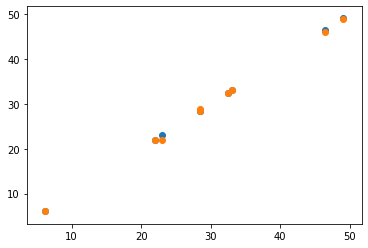

In [17]:
plt.scatter(true_spacev_uvw, true_spacev)
plt.scatter(true_spacev_uvw, calc_spacev)

In [18]:
from astropy.table import Table


In [19]:
descrepancies = Table([cluster_names, ang_seps, dist_seps],names=('Cluster','Ang.Sep.','Dist'))
descrepancies['Ang.Sep.'].unit = u.arcsecond
descrepancies['Ang.Sep.'].info.format = '.2f'
descrepancies['Dist'].unit = u.pc
descrepancies['Dist'].info.format = '.2f'

descrepancies['SpaceVel%'] = 100.0*(np.abs(calc_spacev-true_spacev_uvw)/true_spacev_uvw)
descrepancies['SpaceVel%'].info.format = '.2f'
descrepancies['SpaceVel%'].unit = u.percent

## Plots of Astrometrics

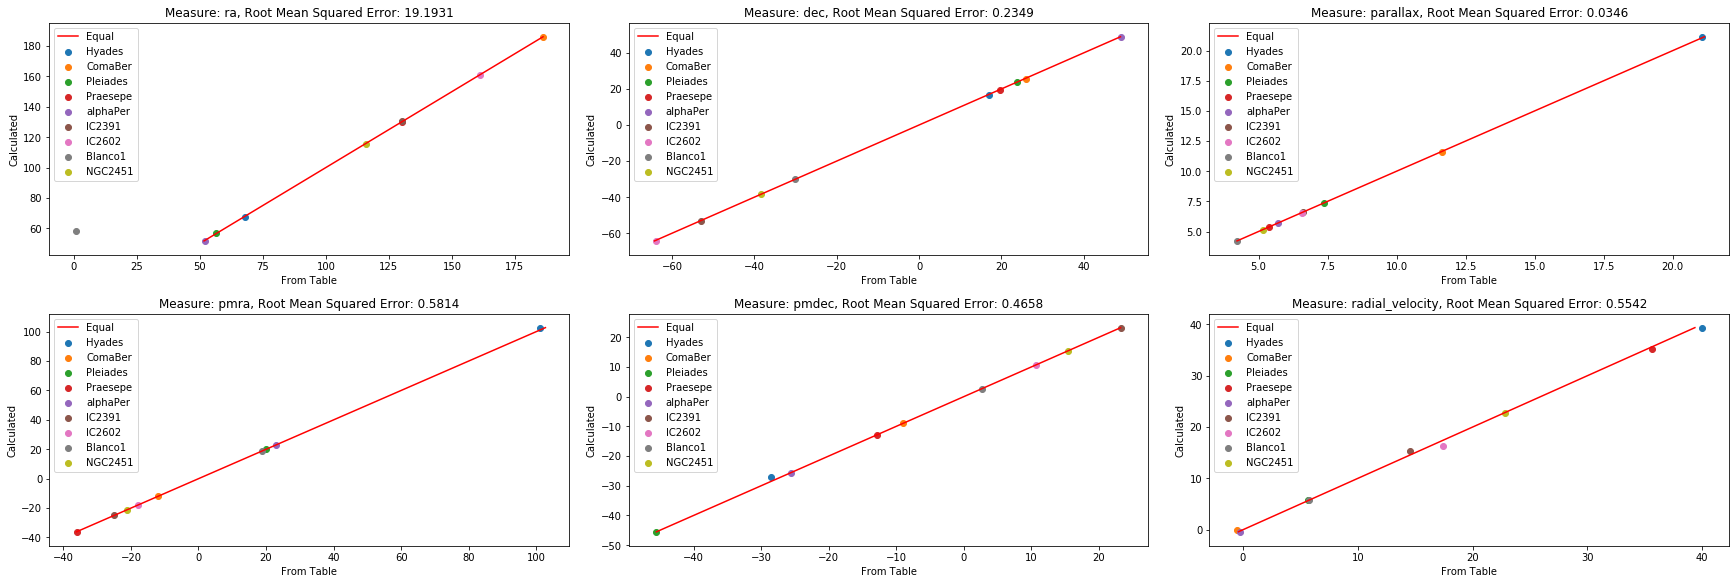

In [20]:

fig = plt.figure(figsize=(24,8),constrained_layout=True)
axs = fig.subplots(2,3)
for m, ax in zip(['ra', 'dec','parallax','pmra', 'pmdec','radial_velocity'], axs.flatten()):
    plot_measure(ax, m)



## Discrepancies in Separation, Distance, and Space Velocity

In [21]:
print(descrepancies)

Cluster   Ang.Sep.  Dist  SpaceVel%
           arcsec    pc       %    
-------- --------- ------ ---------
  Hyades   1167.41   0.35      0.90
 ComaBer   1645.09   0.71      0.74
Pleiades    957.80   0.63      0.01
Praesepe    460.22   0.42      0.44
alphaPer   1054.61   0.90      0.18
  IC2391    498.63   0.39      1.17
  IC2602   1553.24   1.15      4.09
 Blanco1 177496.07 197.76      0.12
 NGC2451    666.87   0.64      0.32


In [22]:
def calculate_precision(measure):
    NMemb = dict([(cl, np.isfinite(cluster_members[cl].objs[measure]).sum()) for cl in cluster_names])
    df = pd.DataFrame([[
                    cluster_means.loc[cl][measure],
                    cluster_sds.loc[cl][measure], NMemb[cl],
                  cluster_sds.loc[cl][measure]/np.sqrt(NMemb[cl]),
                  cluster_info.loc[cl][measure+'_error']] for cl in cluster_names],
                index=cluster_names, columns=['mean','sd','NMemb','Precision', 'Reported'])
    return df

In [23]:
calculate_precision('pmra')

,mean,sd,NMemb,Precision,Reported
Hyades,102.742181,24.912271,515,1.097766,0.171
ComaBer,-12.061348,0.770044,153,0.062254,0.048
Pleiades,19.957308,1.267896,1326,0.034819,0.127
Praesepe,-36.116239,1.563322,938,0.051044,0.110
alphaPer,22.860010,1.129809,740,0.041533,0.071
IC2391,-24.878739,1.366538,325,0.075802,0.080
IC2602,-17.691835,1.515203,492,0.068311,0.040
Blanco1,18.747896,0.518686,489,0.023456,0.017
NGC2451,-21.061662,1.005815,400,0.050291,0.065


In [24]:
calculate_precision('pmdec')

,mean,sd,NMemb,Precision,Reported
Hyades,-27.098107,15.682757,515,0.691065,0.137
ComaBer,-8.916751,0.924510,153,0.074742,0.121
Pleiades,-45.513762,1.646605,1326,0.045219,0.101
Praesepe,-12.935581,1.134731,938,0.037050,0.066
alphaPer,-25.544878,1.132225,740,0.041621,0.095
IC2391,23.212817,1.201703,325,0.066659,0.110
IC2602,10.594724,1.726089,492,0.077818,0.098
Blanco1,2.653651,0.454713,489,0.020563,0.070
NGC2451,15.336960,0.854033,400,0.042702,0.093


In [25]:
def rms(x):
    ss=(x**2).sum()
    n=len(x)
    return np.sqrt(ss/n)

In [26]:
rms(cluster_members['Pleiades'].objs.pmra_error)

0.3217773292084974

In [27]:
calculate_precision('parallax')

,mean,sd,NMemb,Precision,Reported
Hyades,21.152856,2.438442,515,0.107451,0.065
ComaBer,11.617585,0.392339,153,0.031719,0.034
Pleiades,7.361906,0.283196,1326,0.007777,0.005
Praesepe,5.368827,0.174543,938,0.005699,0.003
alphaPer,5.719444,0.199096,740,0.007319,0.005
IC2391,6.591583,0.217786,325,0.012081,0.007
IC2602,6.570311,0.222816,492,0.010045,0.007
Blanco1,4.220506,0.124176,489,0.005615,0.003
NGC2451,5.159384,0.150336,400,0.007517,0.005


In [28]:
calculate_precision('radial_velocity')

,mean,sd,NMemb,Precision,Reported
Hyades,39.363919,3.139583,156,0.251368,0.06
ComaBer,0.049177,3.122300,51,0.437209,0.07
Pleiades,5.798103,4.853011,239,0.313915,0.09
Praesepe,35.265767,2.524555,182,0.187132,0.10
alphaPer,-0.386599,5.570043,99,0.559810,0.08
IC2391,15.273224,3.038396,48,0.438555,0.09
IC2602,16.239014,4.388653,52,0.608597,0.11
Blanco1,5.865767,3.099975,57,0.410602,0.10
NGC2451,22.705703,7.435397,43,1.133887,0.09


In [29]:
def plot_error(ax,measure):
    df = calculate_precision(measure)
    eqline = np.linspace(df.Reported.min(),df.Reported.max(), 1000)
    ax.plot(eqline, eqline, color='red', ls='--', label='Equal')
    ax.plot(eqline, 2.0*eqline, color='blue', ls='--', label='2x')
    for cl in cluster_names:
        ax.scatter(df.loc[cl].Reported, df.loc[cl].Precision, label=cl)
    ax.legend()
    ax.set_title(f'Measure: {measure} Error')
    ax.set_ylabel('Calculated')
    ax.set_xlabel('Reported')
    

## Uncertainty

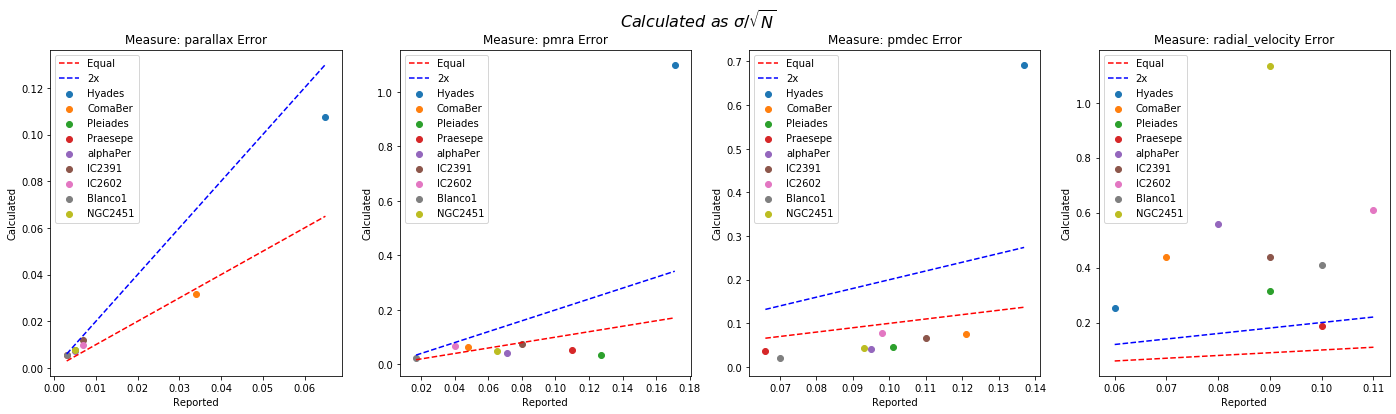

In [30]:
fig = plt.figure(figsize=(24,6))
axs = fig.subplots(1,4)
for m, ax in zip(['parallax','pmra','pmdec','radial_velocity'], axs):
    plot_error(ax, m)
zz=fig.suptitle('$Calculated\ as\ \sigma/\sqrt{N}$', size=16)

In [31]:
cluster_info.loc['Hyades']['radial_velocity_error']

0.06

In [32]:
cluster_members['Hyades'].objs.radial_velocity.std(ddof=1)

3.139583378861333

In [33]:
rvdf = pd.DataFrame([[cluster_members[cl].objs.radial_velocity.mean(), cluster_members[cl].objs.radial_velocity.std(ddof=1),
              np.isfinite(cluster_members[cl].objs.radial_velocity).sum()] for cl in cluster_names],
              index=cluster_names, columns=['MeanRV','SigmaRV','Nobs'])
rvdf['Precision'] = rvdf.SigmaRV/np.sqrt(rvdf.Nobs)
rvdf['Reported'] = np.array([cluster_info.loc[cl]['radial_velocity_error'] for cl in cluster_names])
rvdf['Ratio'] = rvdf.Precision/rvdf.Reported
rvdf['MeanError'] = cluster_means.radial_velocity_error

rvdf

,MeanRV,SigmaRV,Nobs,Precision,Reported,Ratio,MeanError
Hyades,39.363919,3.139583,156,0.251368,0.06,4.189464,0.569454
ComaBer,0.049177,3.122300,51,0.437209,0.07,6.245849,1.285943
Pleiades,5.798103,4.853011,239,0.313915,0.09,3.487947,2.858925
Praesepe,35.265767,2.524555,182,0.187132,0.10,1.871324,1.683819
alphaPer,-0.386599,5.570043,99,0.559810,0.08,6.997630,3.905128
IC2391,15.273224,3.038396,48,0.438555,0.09,4.872830,3.825926
IC2602,16.239014,4.388653,52,0.608597,0.11,5.532697,4.036832
Blanco1,5.865767,3.099975,57,0.410602,0.10,4.106018,2.298944
NGC2451,22.705703,7.435397,43,1.133887,0.09,12.598750,3.383824


In [34]:
cluster_info.columns

<TableColumns names=('cluster','ra','dec','U','e_U','V','e_V','W','e_W','cUV','cUW','cVW','ra_conv','dec_conv','parallax','parallax_error','pmra','pmra_error','pmdec','pmdec_error','NMemb','uwsd','radial_velocity','radial_velocity_error','coords','DM','log_age','Fe_H','e_b_minus_v','NMembers','Z')>

In [35]:
np.array([cluster_info.loc[cl]['radial_velocity_error'] for cl in cluster_names])

array([0.06, 0.07, 0.09, 0.1 , 0.08, 0.09, 0.11, 0.1 , 0.09])

In [36]:
def weighted_mean(means, errors):
    err_sq = errors**2
    inv_err_sq_sum = (1/err_sq).sum()
    
    xbar = (means/err_sq).sum()/inv_err_sq_sum
    
    sigma = np.sqrt(1/inv_err_sq_sum)
    
    return {'weighted_mean': xbar, 'sigma': sigma}

In [37]:
weighted_mean(cluster_members['Pleiades'].objs.pmra, cluster_members['Pleiades'].objs.pmra_error)

{'weighted_mean': 20.10952252501146, 'sigma': 0.0038532992832822108}

In [38]:
cluster_info.loc['Pleiades'][['pmra','pmra_error','NMemb']]

pmra,pmra_error,NMemb
float64,float64,int64
19.997,0.127,1326


In [39]:
df = cluster_members['Pleiades'].objs.copy()
rv_stars = np.isfinite(df.radial_velocity)
c_ok = (df.phot_bp_mean_mag - df.phot_rp_mean_mag) >0.4

In [40]:
np.logical_and(rv_stars, c_ok).sum()

237

## Least Squares Space Motion

See (https://www.aanda.org/articles/aa/full_html/2017/05/aa30552-17/aa30552-17.html) equation 3.

In [43]:
cluster_info.loc['Hyades'][['U','V','W']]

U,V,W
float64,float64,float64
-6.059,45.691,5.544


In [45]:
(1*u.kpc/u.year).to(u.km/u.second)

<Quantity 9.77792222e+08 km / s>

In [50]:
((1*u.mas).to(u.radian)*1*u.kpc/u.year/u.radian).to(u.km/u.second)

<Quantity 4.74047046 km / s>

In [51]:
4.740470463496208

4.740470463496208

In [103]:
from scipy.optimize import minimize

def sum_of_squares(d_xyz, tang_v, A):
    space_v = d_xyz.reshape(-1,1)
    tang_v_hat = A.dot(space_v)
    errors_squared = (tang_v-tang_v_hat)**2
    return errors_squared.sum()

def ls_pm(objs):
    k = 4.740470463496208 #1 mas/year at 1kpc to km/s
    
    #tangental velocities for the stars (stars x {pmra, pmdec} x 1) in km/s
    tang_v = np.array([k*objs.pmra/objs.parallax, k*objs.pmdec/objs.parallax]).T.reshape(-1,2,1)
    
    alpha = np.radians(objs.ra); delta = np.radians(objs.dec)
    n = len(objs)
    
    #projection matrix A
    A = np.array([-np.sin(alpha), np.cos(alpha), np.zeros(n),
                 -np.cos(alpha)*np.sin(delta), -np.sin(alpha)*np.sin(delta), np.cos(delta)]).T.reshape(-1,2,3)
    
    
    init_guess = np.array([0.0,0.0, 0.0]) # to  be improved later
    
    result = minimize(sum_of_squares,init_guess, args=(tang_v, A))
    
    return result

In [111]:
result = ls_pm(cluster_members['alphaPer'].objs)
result

      fun: 643.685753159432
 hess_inv: array([[0.08655083, 0.10857117, 0.15911507],
       [0.10857117, 0.13794238, 0.20116854],
       [0.15911507, 0.20116854, 0.29549596]])
      jac: array([-7.62939453e-06,  7.62939453e-06,  7.62939453e-06])
  message: 'Optimization terminated successfully.'
     nfev: 70
      nit: 8
     njev: 14
   status: 0
  success: True
        x: array([ -5.07412772,  24.16182668, -14.14396763])

In [112]:
cluster_info.loc['alphaPer'][['U','V','W']]

U,V,W
float64,float64,float64
-5.11,24.183000000000003,-14.122


In [85]:
space_v = np.array([*cluster_info.loc['Hyades'][['U','V','W']].as_void()]).reshape(-1,1)

In [86]:
space_v

array([[-6.059],
       [45.691],
       [ 5.544]])

In [87]:
A.dot(space_v)

array([[[24.88613189],
        [-9.22896128]],

       [[27.96260908],
        [-6.17332709]],

       [[28.21569552],
        [-7.52515875]],

       ...,

       [[20.15203051],
        [-5.71492623]],

       [[20.32464916],
        [-5.3882314 ]],

       [[19.95601763],
        [-5.31745907]]])

In [90]:
A.dot(space_v)-tang_v.T.reshape(-1,2,1)

array([[[ 0.151464  ],
        [-0.41880387]],

       [[-0.45902157],
        [-0.17431726]],

       [[ 0.01344657],
        [ 0.14061303]],

       ...,

       [[-0.01272849],
        [ 0.02319132]],

       [[ 1.18228601],
        [-0.0837999 ]],

       [[ 0.17303157],
        [ 0.18791088]]])

In [92]:
tv = tang_v.T.reshape(-1,2,1)

In [98]:
np.array([*tv.mean(axis=0).flatten(),0])

array([22.83947745, -6.15883263,  0.        ])

In [95]:
tv

array([[[24.73466789],
        [-8.81015741]],

       [[28.42163065],
        [-5.99900983]],

       [[28.20224896],
        [-7.66577178]],

       ...,

       [[20.16475899],
        [-5.73811755]],

       [[19.14236315],
        [-5.3044315 ]],

       [[19.78298606],
        [-5.50536996]]])